<a href="https://colab.research.google.com/github/ftrfr/CRAFT-pytorch/blob/master/baseCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
TPU = False #@param {type:"boolean"}

BATCH_SIZE = 32 #@param ["16","32","64","128"] {type:"raw"}
DATA = "FHT" #@param ["FHT", "GEM","steelcut"] {type:"string"}
KIND = "res" #@param ["dense", "res", "mobile","vgg16", "vgg19"] {type:"string"}
MIN_EPOCHS = 54 #@param {type:"slider", min:0, max:100, step:1}
MAX_EPOCHS = 20 #@param {type:"slider", min:0, max:100, step:1}

#@markdown ---

#@markdown # base network 를 ImageNet pretrained weights 로 초기화 할지 or From Scratch 
Pretrained = True #@param {type:"boolean"}
#@markdown ---

#@markdown # base network 를 커스텀  pretrained weights 로 초기화 할지 or From Scratch 
WEIGHT = True #@param {type:"boolean"}
#@markdown ---

#@markdown ### Freeze phase : pretrained layer 를 전부 freeze 한 상태로 추가한 뒷 단 레이어만 학습하는 phase를 넣을 것인가 before Fine Tuning 
FREEZE = True #@param {type:"boolean"}

#@markdown ### freeze phase 에폭 수 
FREEZE_EPOCHS = 12 #@param {type:"slider", min:0, max:24, step:1}

#@markdown # Early Stopping
EARLY_STOP = True #@param {type:"boolean"}

#@markdown ---

#@markdown # WandB 에 모델을 저장할지 말지. 
save_on_wandb = True #@param ["True", "False"] {type:"raw"}
#@markdown ---

#@markdown # metric (test or valid) 이 이 값을 넘으면 슬랙 알림 
THRESHOLD = 0.7 #@param ["0.7","0.8","0.9","0.95"] {type:"raw"}  
#@markdown ---

#@markdown # hparams sweep 을 할 지 single Run 할지 
SWEEP = True #@param ["True", "False"] {type:"raw"}


#@markdown ---

#@markdown # 하이퍼파라미터 sweep 을 돌릴 Run 의 수 
COUNT = 125 #@param {type:"slider", min:0, max:300, step:5}

# resume 해서 이어서 학습, RUN_ID 지정 해줘야 함. 
#@markdown ---

#@markdown # resume 해서 이어서 학습 ( single Run 인 경우만 ) 웹상에 체크포인트 저장. 구글드라이브에 저장할 필요 X 
RESUME = True #@param ["True", "False"] {type:"raw"} 
#@markdown ---

#@markdown # Run ID 입력 ( resume 인 경우 )
RUN_ID = ''  #@param {type:"string"}

augmentation = True     # 무조건 True 



# 하이퍼 파라미터 서치 스페이스 설정

In [ ]:
sweep_config = {
    'method': 'bayes',  # Randomly sample the hyperparameter space (alternatives: grid, bayes)
    'metric': {         # This is the metric we are interested in minimizing
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    # Paramters and parameter values we are sweeping across
    'parameters': {
        'max_epoch' : {
            'value' : MAX_EPOCHS
            #'values' : [100,200]
        },
        'learning_rate': {
            'values': [0.001, 0.0001, 0.00002]
            #'value' : 0.00002
        },
        'scheduler': {
            'values': ['cosine', 'RoP']
            #'values': ['cosine','lambda','cosineWR', 'RoP']
            #'value': 'RoP'
        },
        
        't_0': {
            #'values': [50,100,150]
            'value' : MAX_EPOCHS
        },        

        'batch_size': {
            'value' : BATCH_SIZE
        },
        'kind': {
            # 'values': ['dense', 'res', 'mobile']
             'value': KIND
        },

        'optimizer': {
            #'values': ['SGD', 'Adam', 'RMSprop', 'AdamW']
            'values': ['SGD', 'AdamW']
        },

        'fc_layer_size': {
            #'values' : [(256,128,64), (126,64,32), (64,32,16)]
            'value' : (256,128,64) 
        },

        'weight_decay': {
            #'distribution' : 'uniform',
            #'min' : 0 ,
            #'max' : 0.1
            'values' : [0, 0.01, 0.1, 0.5]
           
        },
        'normalize': { 
            #'values' : [True, False]
            'value' : True
        },

        # momentum

        'dropout' : { 
            'values' : [0.2, 0.5, 0.7]
            #'value' : 0.2 
        },
        # augmentation kind 

        # activation kind 

        # adamW eps 


        'num_layers' : {
            'values': [30,40,50,60]
            #'value': 40
        }
}
}

In [ ]:
WORKERS = 8 
# TPU 학습 가능한 버전 패키지 버전 설치 WORKERS 는 dataloader에 쓰이는 CPU 코어 개수 
if TPU:
  WORKERS=40
  !pip install -qqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
  !pip install -qqq torch==1.9
  !pip install -qqq torchtext==0.10


!pip install -qqq pytorch-lightning
!pip install -qqq wandb
#!pip install git+https://github.com/rwightman/pytorch-image-models
#!pip install "ray[tune]"
#!pip install -qqq pretrainedmodels

In [ ]:
!pip list | grep torch

pytorch-lightning             1.5.10
torch                         1.9.0
torch-xla                     1.9
torchaudio                    0.10.0+cu111
torchmetrics                  0.7.3
torchsummary                  1.5.1
torchtext                     0.10.0
torchvision                   0.11.1+cu111


In [ ]:
import os
#import pretrainedmodels
# Weights & Biases
import wandb
from wandb import AlertLevel
from datetime import timedelta

# import timm
# from timm.scheduler import CosineLRScheduler

# from ray import tune
# from ray.tune.integration.wandb import WandbLogger

#from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LambdaLR, CosineAnnealingLR, CyclicLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import torch 

# Pytorch modules
from torch.nn import functional as F
from torch import nn
from torch.optim import Adam, SGD, RMSprop, AdamW 
from torch.utils.data import DataLoader, random_split, Dataset

# Pytorch-Lightning
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
import pytorch_lightning as pl
import torchmetrics
# Dataset
from torchvision.datasets import MNIST, ImageFolder
from torchvision import transforms, models

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/xla_device.py", line 32, in inner_f
    queue.put(func(*args, **kwargs))
  File "/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/xla_device.py", line 73, in _is_device_tpu
    return (xm.xrt_world_size() > 1) or bool(xm.get_xla_supported_devices("TPU"))
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 136, in get_xla_supported_devices
    xla_devices = _DEVICES.value
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/utils/utils.py", line 32, in value
    self._value = self._gen_fn()
  File "/usr/local/lib/python3.7/dist-packages/torch_xla/core/xla_model.py", line 18, in <lambda>
    _DEVICES = xu.LazyProperty(lambda: torch_xla._XLAC._xla_get_devices())
RuntimeError: tensorflow/compiler/xla/xla_client/computation_client.cc:273 : Missing XLA configuration


# 처음 한번 wandb 계정에 로그인 필요 

계정의 api key 복붙하고 Enter

In [ ]:
wandb.login()

wandb: Currently logged in as: sunghan (use `wandb login --relogin` to force relogin)


True

데이터 별로 wandb 프로젝트 이름과 data 경로



In [ ]:
if DATA =='GEM':
  project = 'GEM_classifier'
  main_dir = '/content/data/D5_GEM'
elif DATA == 'FHT':
  project = "FHT"
  main_dir = '/content/data/D5_FHT'
elif DATA == 'steelcut':
  project = "GEM_classifier"
  main_dir = '/content/data/split_2'

project = DATA 

train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'val')

# dataset setting in disk 

In [ ]:
import shutil
import zipfile
if DATA =='GEM':
  directory_to_extract_to = '/content/data'
  if not os.path.exists(directory_to_extract_to+'/D5_GEM/train'):
    os.makedirs(directory_to_extract_to, exist_ok=True)
    source_path = '/content/drive/Shareddrives/data/D5_GEM.zip'
    shutil.copy(source_path, directory_to_extract_to) 
    sent_file = os.path.join(directory_to_extract_to, os.path.basename(source_path))
    with zipfile.ZipFile(sent_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to) 
    print('지금 데이터 옮겼음')
  else:
    print('이미 데이터 VM 내부로 복사')
if DATA =='FHT':
  directory_to_extract_to = '/content/data'
  if not os.path.exists(directory_to_extract_to+'/D5_FHT/train'):
    os.makedirs(directory_to_extract_to, exist_ok=True)
    source_path = '/content/drive/Shareddrives/data/D5_FHT.zip'
    shutil.copy(source_path, directory_to_extract_to) 
    sent_file = os.path.join(directory_to_extract_to, os.path.basename(source_path))
    with zipfile.ZipFile(sent_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to) 
    print('지금 데이터 옮겼음')
  else:
    print('이미 데이터 VM 내부로 복사')
if DATA == 'steelcut':
  # 데이터를 복사해서 압축해제할 코랩 VM 로컬 폴더 생성해 놓기 
  directory_to_extract_to = '/content/data/split_2'
  if not os.path.exists(directory_to_extract_to + '/train'):
    os.makedirs(directory_to_extract_to, exist_ok=True)
    shutil.copy('/content/drive/Shareddrives/data/my_split_2.zip','/content/data') 
    directory_to_extract_to = '/content/data/split_2'
    os.makedirs(directory_to_extract_to, exist_ok=True)
    with zipfile.ZipFile('/content/data/my_split_2.zip', 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)     
    print('지금 데이터 가져옴')
  else:
    print('이미 데이터 VM 내부로 복사')

이미 데이터 VM 내부로 복사


In [ ]:
os.chdir('/content')

Normalize 위한 mean, std of train dataset 계산 

In [ ]:
mean = 0.
std = 0.

dataset = ImageFolder(train_dir, transforms.Compose([            
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ]))
just_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
for images, _ in just_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(just_loader.dataset)
std /= len(just_loader.dataset)
mean = mean.tolist()
std = std.tolist()
print(mean,std)

[0.6267774105072021, 0.6248263120651245, 0.579587996006012] [0.11603343486785889, 0.11710626631975174, 0.11700515449047089]


mean = [0.6227, 0.6214, 0.5771]
std =  [0.1150, 0.1161, 0.1159]

# Data Augmentation   좀 더 정교화 할 부분  


In [ ]:
from torchvision import transforms
# Train 용 
transform_train_look = transforms.Compose([            
        transforms.Resize((224, 224)),                       
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(90),

        # transforms.ColorJitter(brightness=0.5,
        #                        contrast=0.5,
        #                        saturation=0.5,
        #                        hue=0.5),
        
        transforms.ColorJitter(brightness=(0.8,1.1)),

        transforms.RandomResizedCrop(224,scale=(0.8,1.2),ratio=(0.99,1.01) ),
        #transforms.Grayscale(3),
        transforms.ToTensor()
        ]) 

transform_train = transforms.Compose([            
        transform_train_look,
        transforms.Normalize(mean, std)
        ])     
# Valid, Test 용 
transform_valid_look = transforms.Compose([            
        transforms.Resize((224, 224)),
        #transforms.Grayscale(3),                         
        transforms.ToTensor()
        ])       

transform_valid = transforms.Compose([            
        transform_valid_look,
        transforms.Normalize(mean, std)                                 
        ])       



In [ ]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)


# Dataloader 선언 Data Augmentation 예시 시각화 for one image



Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.float32


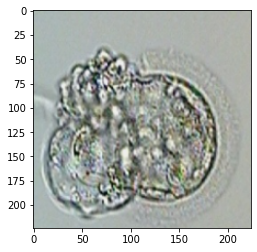

Label: 0
tensor(0.0667) tensor(0.9412)
torch.float32


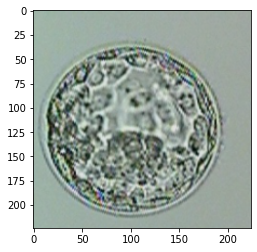

Label: 1
tensor(0.0510) tensor(0.8902)
torch.float32


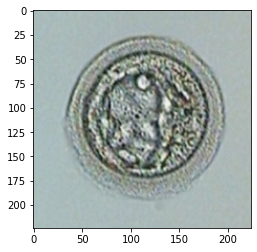

Label: 0
tensor(0.0784) tensor(0.9490)
torch.float32


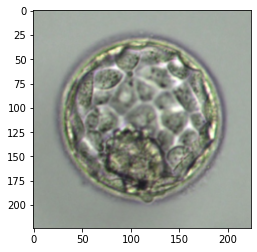

Label: 1
tensor(0.1020) tensor(1.)
torch.float32


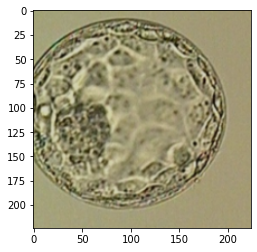

Label: 1
tensor(0.0431) tensor(0.8275)
torch.float32


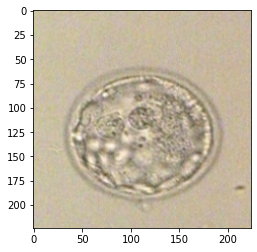

Label: 0
tensor(0.3020) tensor(0.9843)
torch.float32


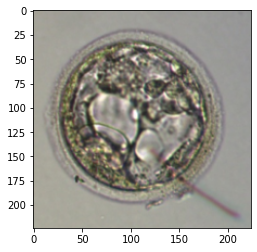

Label: 0
tensor(0.1216) tensor(1.)
torch.float32


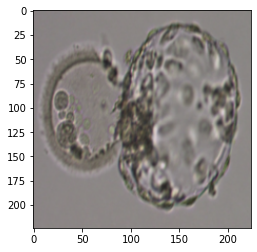

Label: 1
tensor(0.1294) tensor(0.8039)
torch.float32


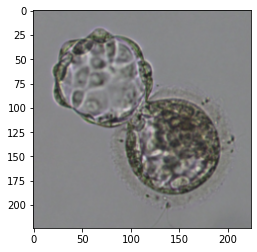

Label: 1
tensor(0.1255) tensor(0.8431)
torch.float32


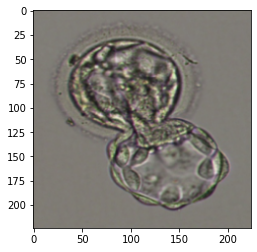

Label: 1
tensor(0.0706) tensor(0.9176)
torch.float32


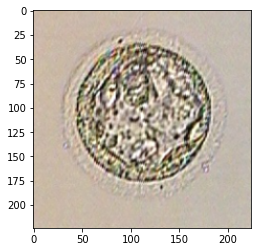

Label: 0
tensor(0.0314) tensor(1.)
torch.float32


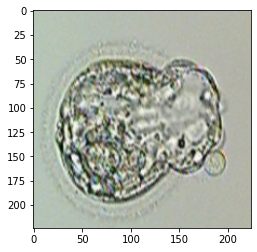

Label: 1
tensor(0.0392) tensor(0.9686)
torch.float32


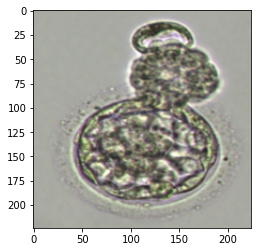

Label: 1
tensor(0.1216) tensor(1.)
torch.float32


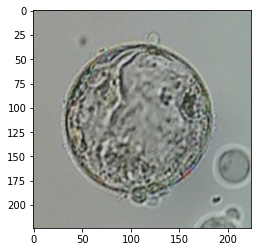

Label: 0
tensor(0.0588) tensor(0.8196)
torch.float32


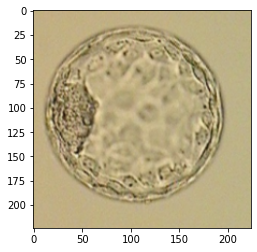

Label: 1
tensor(0.0941) tensor(0.9020)
torch.float32


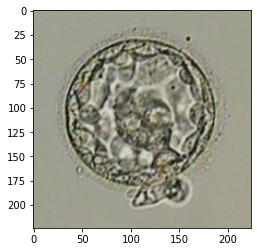

Label: 1
tensor(0.0471) tensor(0.8353)
torch.float32


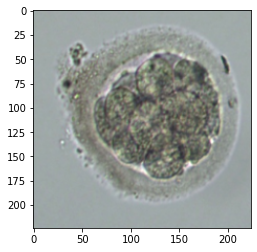

Label: 1
tensor(0.1569) tensor(0.9961)
torch.float32


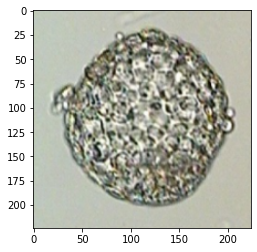

Label: 1
tensor(0.0392) tensor(0.9922)
torch.float32


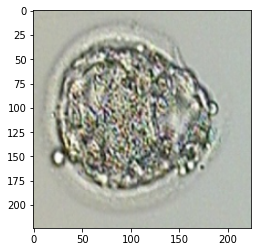

Label: 1
tensor(0.0588) tensor(0.9882)
torch.float32


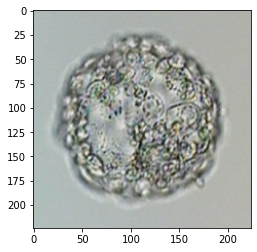

Label: 1
tensor(0.0667) tensor(0.9176)
torch.float32


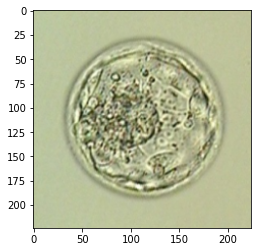

Label: 1
tensor(0.1176) tensor(0.9961)
torch.float32


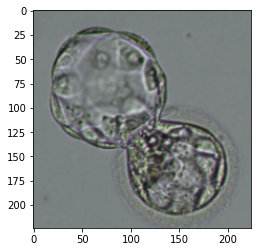

Label: 1
tensor(0.0745) tensor(0.8039)
torch.float32


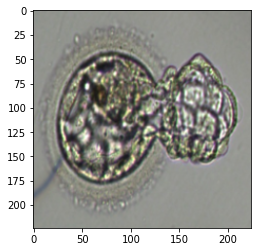

Label: 1
tensor(0.0941) tensor(1.)
torch.float32


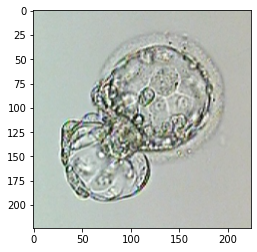

Label: 1
tensor(0.0471) tensor(1.)
torch.float32


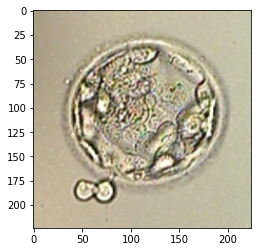

Label: 1
tensor(0.0392) tensor(1.)
torch.float32


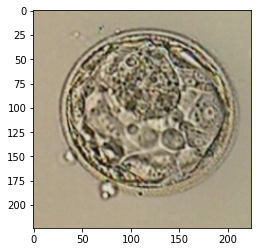

Label: 1
tensor(0.0392) tensor(0.8706)
torch.float32


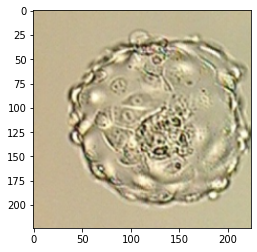

Label: 1
tensor(0.0706) tensor(1.)
torch.float32


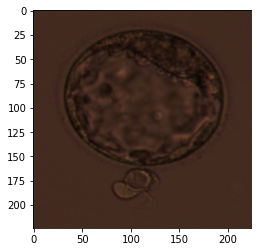

Label: 1
tensor(0.0235) tensor(0.2863)
torch.float32


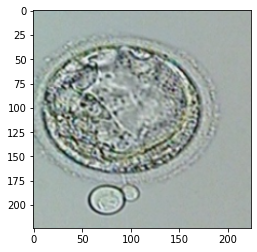

Label: 0
tensor(0.0431) tensor(0.9490)
torch.float32


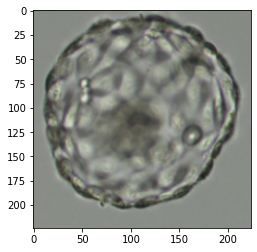

Label: 1
tensor(0.1098) tensor(0.8706)
torch.float32


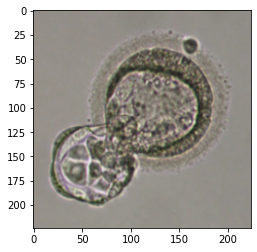

Label: 1
tensor(0.1373) tensor(0.8980)
torch.float32


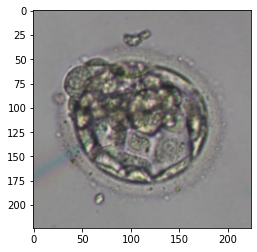

Label: 1
tensor(0.1294) tensor(0.8902)


In [ ]:
test_dataloader = DataLoader(ImageFolder(test_dir,transform_valid), batch_size=BATCH_SIZE)

# train/val split 
dataset = ImageFolder(train_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
td, vd = torch.utils.data.random_split(dataset, [train_size, val_size])

if not augmentation:
  train_dataset = MyDataset(td, transform = transform_valid)
else:
  train_dataset = MyDataset(td, transform = transform_train)
val_dataset = MyDataset(vd, transform = transform_valid)

train_dataloader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE )

td_look = MyDataset(td, transform = transform_train_look)
vd_look = MyDataset(vd, transform = transform_valid_look)

train_loader_look =  DataLoader(td_look, batch_size=BATCH_SIZE )
test_loader_look = DataLoader(val_dataset, batch_size=BATCH_SIZE )

train_features, train_labels = next(iter(train_loader_look))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(BATCH_SIZE):
  img = train_features[i].squeeze()
  label = train_labels[i]
  img = img.T
  print(img.dtype)
  #img = 255*img
  #img = np.clip(img,0,1)
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")
  print(torch.min(img[:,:,1]), torch.max(img[:,:,1]))

In [ ]:
# torchvision 에 NasnetLarge 가 없어서 다른 pytorch 구현 오픈 소스 라이브러리 설치
#print(pretrainedmodels.model_names)

In [ ]:
class backbone (nn.Module):

    def __init__(self,kind =None, TRAINED=True):
        super(backbone, self).__init__()

        # Keras include_top=False 구현은 일관성 있는데, torchvision models 구현이 일관되지 않음. 
        self.kind = kind 
        
        if kind is 'dense':
          bb = models.densenet201(pretrained=TRAINED)
          self.features = nn.Sequential(*list(bb.children())[:-1])

        if kind is 'res':
          bb = models.resnet152(pretrained=TRAINED)
          self.features = nn.Sequential(*list(bb.children())[:-2])

        if kind is 'mobile':
          bb = models.mobilenet_v2(pretrained=TRAINED)
          self.features = nn.Sequential(*list(bb.children())[:-1])

        if kind is 'vgg16':
          bb = models.vgg16(pretrained=TRAINED)
          self.features = nn.Sequential(*list(bb.children())[:-2])

        if kind is 'vgg19':
          bb = models.vgg19_bn(pretrained=TRAINED)
          self.features = nn.Sequential(*list(bb.children())[:-2])
        
        # layer를 class로 정의 
        self.bn = nn.BatchNorm2d(2048)
        self.relu = nn.ReLU()


    # Set your own forward pass
    def forward(self, img, extra_info=None):

        if self.kind is 'dense':
          x = self.features(img)
          out = F.relu(x, inplace=True)

        if self.kind is 'res':
          x = self.features(img)
          x = self.bn(x)
          out = self.relu(x)


        if self.kind is 'mobile':
          out = self.features(img)
        
        if self.kind is 'vgg16':
          out = self.features(img)

        if self.kind is 'vgg19':
          out = self.features(img)

      
        return out



In [ ]:
# 수정 해야함. 
def set_parameter_requires_grad(model, feature_extracting, num_layer):
    count = 0 
    for name, module in model.named_modules():
      count += 1
    print('total', count )
    start = count - num_layer
    if feature_extracting:
      for param in model.parameters():
          param.requires_grad = False
          count += 1
      ct = 0 
      for name, module in model.named_modules():
          ct += 1 
          if ct > start:
            for param in module.parameters():
              param.require_grad = True
              print(ct,name,param.require_grad)

In [ ]:
# Pytorch 구현 모델 코드 # 한번 concise하게 확인 해야함 
def convbase(model_name, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "dense":
        """ DenseNet201
        """
        model_ft = backbone(model_name)


    elif model_name == "mobile":
        """ MobilenetV2 
        """
        model_ft = backbone(model_name)

    elif model_name == "res":
        """ Resnet152V2
        """
        model_ft = backbone(model_name)

    elif model_name == "vgg16":
        """ VGG 16
        """
        model_ft = backbone(model_name)

    elif model_name == "vgg19":
        """ VGG 19 
        """
        model_ft = backbone(model_name)

    else:
        print("Invalid model name, exiting...")
        
    return model_ft

convbase input shape output shape 테스트 

In [ ]:
class GEM(LightningModule):

    def __init__(self, kind, optimizer='SGD', lr=1e-3, wd = 0.9, fc_layers = (256,128, 64), dropout=0.2, t_0=2, scheduler='cosine'):
        '''method used to define our model parameters'''
        super().__init__()

        self.convbase = convbase(kind, True, use_pretrained=Pretrained)

        
        # 여기서 feature extractor의 output size 계산 코드 
        # 더미 이미지로,
        out  = self.convbase(torch.rand(1,3,224,224))
        shape = list(out.size())
        out_size = shape[1]*shape[2]*shape[3]

        # print(out_size)



        self.flatten = nn.Flatten()

        num_fc =  len(fc_layers)
        self.num_fc = num_fc 

        self.dense = dict()

        self.activation = nn.SELU()


        self.dropout = nn.Dropout(dropout)

        for i in range(num_fc + 1):
          if i == 0 : 
            self.dense[i] =  nn.Linear( out_size , fc_layers[i])  
          elif i == num_fc:
            self.dense[i] = nn.Linear( fc_layers[i-1], 1 )
          else:
            self.dense[i] =  nn.Linear( fc_layers[i-1] , fc_layers[i]) 



        # optimizer parameters
        self.lr = lr
        self.optimizer = optimizer 
        self.wd = wd 
        self.t_0 = t_0
        self.scheduler = scheduler 

        # # metrics    # test 때 보여줄 지표 
        self.train_accuracy = torchmetrics.Accuracy()
        self.train_auroc = torchmetrics.AUROC()

        self.val_accuracy = torchmetrics.Accuracy()
        self.val_auroc = torchmetrics.AUROC()
        self.valid_acc = torchmetrics.Accuracy()



        self.test_accuracy = torchmetrics.Accuracy()
        self.test_auroc = torchmetrics.AUROC()

        self.smoothing = 0.05 

        #self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''

        x = self.convbase(x)

        # Backbone 이후의 architecture 
        x = self.flatten(x)

        for i in range(self.num_fc):
          x = self.dense[i](x)
          x = self.activation(x)
       

        x = self.dropout(x)
        x = self.dense[self.num_fc](x)

        x = F.sigmoid(x)
        x = x.squeeze(1)

        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        x, y = batch
        logits = self(x)

        # label smoothing 구현 
        mask = y == 1
        add = torch.zeros_like(y.float(), dtype=torch.float)
        add.masked_fill_(~mask, self.smoothing)
        add.masked_fill_(mask, -self.smoothing)
        smoothing_y = torch.add(y.float(), add)
        loss = F.binary_cross_entropy(logits, smoothing_y)


        # Log training loss
        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=False, on_epoch=True)

        # Log metrics
        #self.log('train_acc', self.accuracy(logits, y))

        return {'loss': loss, 'y': y, 'logits':logits }

    def training_epoch_end(self, outputs):
        self.train_accuracy( torch.cat([x["logits"] for x in outputs]), torch.cat([x["y"] for x in outputs]))
        self.train_auroc( torch.cat([x["logits"] for x in outputs]), torch.cat([x["y"] for x in outputs]))
        #self.log('train_accuracy', self.train_accuracy)
        self.log('train_auroc', self.train_auroc)


    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        x, y = batch
        logits = self(x)

        mask = y == 1
        add = torch.zeros_like(y.float(), dtype=torch.float)
        add.masked_fill_(~mask, self.smoothing)
        add.masked_fill_(mask, -self.smoothing)
        smoothing_y = torch.add(y.float(), add)
        loss = F.binary_cross_entropy(logits, smoothing_y)


        # Log validation loss (will be automatically averaged over an epoch)

        # self.val_accuracy(logits, y)
        # self.log('valid_acc', self.val_accuracy, on_step=False, on_epoch=True)
        # self.valid_acc(logits, y)
        # self.log('valid_loss', loss, on_step=True, on_epoch=True)
        # self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)


        # self.val_auroc(logits, y)
        # self.log('valid AUROC', self.val_auroc, on_step=False, on_epoch=True)
        return {'y': y, 'logits': logits}


    def validation_epoch_end(self, outputs):

        #val_acc = self.val_accuracy.compute()

        # if self.best_val_acc < val_acc:
        #     self.best_val_acc = val_acc

        #elf.log("val_acc", val_acc, prog_bar=True)
        # self.log("best_val_acc", self.best_val_acc, prog_bar=True)

        a = torch.cat([x["logits"] for x in outputs])
        b =  torch.cat([x["y"] for x in outputs])
        valid_loss = F.binary_cross_entropy(a, b.float())

        self.log('val_loss', valid_loss)

        self.val_auroc(a, b)
        self.val_accuracy(a,b)
        #self.log('val_accuracy', self.val_accuracy)
        self.log('val_auroc', self.val_auroc)

    def test_step(self, batch, batch_idx):
        '''used for logging metrics'''
        x, y = batch
        logits = self(x)
        loss = F.binary_cross_entropy(logits, y.float())
        return {'y': y, 'logits': logits}
    
    def test_epoch_end(self, outputs):
        self.test_accuracy( torch.cat([x["logits"] for x in outputs]), torch.cat([x["y"] for x in outputs]))
        self.test_auroc( torch.cat([x["logits"] for x in outputs]), torch.cat([x["y"] for x in outputs]))
        self.log('test_accuracy', self.test_accuracy)
        self.log('test_auroc', self.test_auroc)
        return {'test_accuracay': self.test_accuracy, 'test_auroc': self.test_auroc}
    
    def configure_optimizers(self):
        '''defines model optimizer'''

        # optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        # Adam, SGD, RMSprop 
        
        if self.optimizer=='SGD':
          opt = SGD(self.parameters(), lr=self.lr, weight_decay = self.wd)    
        if self.optimizer=='Adam':
          opt = Adam(self.parameters(), lr=self.lr, weight_decay = self.wd) 
        if self.optimizer=='AdamW':
          opt = AdamW(self.parameters(), lr=self.lr, weight_decay = self.wd) 
        if self.optimizer=='RMSprop':
          opt = RMSprop(self.parameters(), lr=self.lr, weight_decay = self.wd) 



        if self.scheduler =='cosine':
          scheduler = CosineAnnealingLR(opt, T_max=self.t_0)
        if self.scheduler =='cosineWR':
          scheduler = CosineAnnealingWarmRestarts(opt, self.t_0)
        if self.scheduler == 'lambda':
          scheduler = LambdaLR(opt, lr_lambda = lambda epoch: 0.95 ** epoch)
        if self.scheduler == 'RoP':
            scheduler = ReduceLROnPlateau(
            opt,
            mode="min",
            verbose=True,
            patience=2
            )    
            sched = {'scheduler':scheduler, 'monitor':'val_loss', 'name': 'learning_rate'}  

        else:
          sched = {'scheduler':scheduler, 'name': 'learning_rate'}  

        return [opt], [sched]



In [ ]:
def set_dataloader(bs, normalize=True):

  if normalize:
    test_dataloader = DataLoader(ImageFolder(test_dir,transform_valid), batch_size=bs)
  else:
    test_dataloader = DataLoader(ImageFolder(test_dir,transform_valid_look), batch_size=bs)


  # train/val split 
  dataset = ImageFolder(train_dir)
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size
  td, vd = torch.utils.data.random_split(dataset, [train_size, val_size])

  if not augmentation:
    train_dataset = MyDataset(td, transform = transform_valid)
  else:
    if normalize:
      train_dataset = MyDataset(td, transform = transform_train)
    else:
      train_dataset = MyDataset(td, transform = transform_train_look)

  if normalize:
    val_dataset = MyDataset(vd, transform = transform_valid)
  else:
    val_dataset = MyDataset(vd, transform = transform_valid_look)


  train_dataloader =  DataLoader(train_dataset, batch_size=bs, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=bs )

  return train_dataloader, val_dataloader, test_dataloader


In [ ]:
def train(config={"learning_rate": 5e-5, "batch_size": 16, "max_epoch": 2}):
  
  with wandb.init(project=project, job_type="train", config=config) as run:  


    # Extract the config object associated with the run
    config = run.config
    
    # Construct our LightningModule with the learning rate from the config object
    model = GEM(kind=KIND, optimizer=config.optimizer, lr=config.learning_rate, wd = config.weight_decay, dropout=config.dropout, t_0 = config.t_0)

    for param in model.convbase.parameters():
      param.requires_grad = False

    # 개수 숫자로 
    total = 0 
    for name, module in model.named_modules():
      total += 1 
    start = total - config.num_layers

    count = 0
    for name, module in model.named_modules():
      count += 1 
      if count >= start :
        for param in module.parameters():
          param.requires_grad = True

    # This logger is used when we call self.log inside the LightningModule
    logger = pl.loggers.WandbLogger(experiment=run, log_model=save_on_wandb)

    lr_monitor = LearningRateMonitor(logging_interval='step')

    early_stopping = EarlyStopping(
    monitor='val_auroc',
    patience=2,
    verbose=True,
    mode='max' )  


    checkpoint = ModelCheckpoint(
    save_last=True,
    save_top_k=1,
    monitor='val_auroc',
    mode='max' )

    early_stopping_2 = EarlyStopping(
    monitor='val_auroc',
    patience=2,
    verbose=True,
    mode='max' )  

    
    # Use as many GPUs as are available
    gpus = -1 if torch.cuda.is_available() else 0

    if EARLY_STOP:
      cbs = [checkpoint, lr_monitor, early_stopping]
    else:
      cbs = [checkpoint, lr_monitor]
    
    # Construct a Trainer object with the W&B logger we created and epoch set by the config object
    if TPU:
      trainer = pl.Trainer(max_epochs=FREEZE_EPOCHS, tpu_cores=1, logger=logger, log_every_n_steps=1, callbacks=[checkpoint, lr_monitor, early_stopping])
    else:
      trainer = pl.Trainer(max_epochs=FREEZE_EPOCHS, gpus=gpus, logger=logger, log_every_n_steps=1, callbacks=[checkpoint, lr_monitor, early_stopping])
    
    #train, val, test = set_dataloader(config.batch_size, config.normalize)

    # train with freeze
    trainer.fit(model, train_dataloader, val_dataloader)

    # fine tuning with all layers unfreeze
    for param in model.convbase.parameters():
      param.requires_grad = True


    # Learning Rate 리셋 
    model.lr = config.learning_rate

    if EARLY_STOP:
      cbs2 = [checkpoint, lr_monitor, early_stopping_2]
    else:
      cbs2 = [checkpoint, lr_monitor]

    if TPU:
      trainer2 = pl.Trainer(max_epochs=config.max_epoch, min_epochs=MIN_EPOCHS, tpu_cores = 1, logger=logger, log_every_n_steps=1, callbacks=cbs2)
    else:
      trainer2 = pl.Trainer(max_epochs=config.max_epoch, min_epochs=MIN_EPOCHS, gpus=gpus, logger=logger, log_every_n_steps=1, callbacks=cbs2)

    trainer2.fit(model, train_dataloader, val_dataloader)

    # callback valid_loss best ckpt test
    trainer.test(model, test_dataloaders=test_dataloader, ckpt_path=checkpoint.last_model_path) 
    trainer.test(model, test_dataloaders=test_dataloader, ckpt_path='best' )
    
    # if result['test_auroc'] > THRESHOLD:
    #   wandb.alert(
    #     title='Good AUROC',
    #     text=f"AUROC: {result['test_auroc']} is above the threshold {THRESHOLD}",
    #     level=AlertLevel.INFO,
    #     wait_duration=timedelta(minutes=1)
    #   )
    # if result2['test_auroc'] > THRESHOLD:
    #   wandb.alert(
    #     title='Good AUROC',
    #     text=f"AUROC: {result['test_auroc']} is above the threshold {THRESHOLD}",
    #     level=AlertLevel.INFO,
    #     wait_duration=timedelta(minutes=1)
    #   )


In [ ]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project=project)

Create sweep with ID: y6zw9xma
Sweep URL: https://wandb.ai/sunghan/FHT/sweeps/y6zw9xma


In [ ]:
# Run an agent 🕵️ to try out 20 hyperparameter combinations
wandb.agent(sweep_id, function=train, count=COUNT)

wandb: Agent Starting Run: un8xzvlx with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: Currently logged in as: sunghan (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0  

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'logits', 'y'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.600


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.600. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.547


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.031 >= min_delta = 0.0. New best score: 0.577


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.611


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.635


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.652


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.662


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.021 >= min_delta = 0.0. New best score: 0.682


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.687


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.705


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.705. Signaling Trainer to stop.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
Restoring states from the checkpoint path at /content/GEM/un8xzvlx/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/un8xzvlx/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7338235378265381}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/un8xzvlx/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/un8xzvlx/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.730147123336792}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: uhs0qvql with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.562


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.562. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.591


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.616


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.021 >= min_delta = 0.0. New best score: 0.637


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.652


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.673


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.679


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.707


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.708


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.710


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.710. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/uhs0qvql/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uhs0qvql/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.612500011920929}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/uhs0qvql/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uhs0qvql/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6058823466300964}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 0pv8m8wa with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.659


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.659. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.636


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.650


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.663


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.685


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.705


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.722


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.722. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/0pv8m8wa/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/0pv8m8wa/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.5566176772117615}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/0pv8m8wa/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/0pv8m8wa/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.5169118046760559}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qpl7pz24 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.810


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.818


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.818


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.802. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/qpl7pz24/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qpl7pz24/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8382353186607361}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/qpl7pz24/checkpoints/epoch=4-step=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qpl7pz24/checkpoints/epoch=4-step=69.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8500000238418579}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 9ygejqp2 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.801
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.842


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.842. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.842. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.842. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.842. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.842. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 7 records. Best score: 0.842. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9ygejqp2/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9ygejqp2/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9108911156654358, 'test_auroc': 0.8683823347091675}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9ygejqp2/checkpoints/epoch=1-step=27.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9ygejqp2/checkpoints/epoch=1-step=27.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9108911156654358, 'test_auroc': 0.841911792755127}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: az7iaedo with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.026 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.029 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.814


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.814. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.828


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.832


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.833


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.833. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/az7iaedo/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/az7iaedo/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8316177129745483}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/az7iaedo/checkpoints/epoch=3-step=55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/az7iaedo/checkpoints/epoch=3-step=55.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.841911792755127}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: gh0f7mjj with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: AdamW
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.802. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 7 records. Best score: 0.785. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/gh0f7mjj/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/gh0f7mjj/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8272058963775635}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/gh0f7mjj/checkpoints/epoch=3-step=55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/gh0f7mjj/checkpoints/epoch=3-step=55.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8250000476837158}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: z5cp0mhs with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.742


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.033 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.808
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.752. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.778. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/z5cp0mhs/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/z5cp0mhs/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.8654411435127258}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/z5cp0mhs/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/z5cp0mhs/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8558824062347412}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 09u9f4b8 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.519


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.053 >= min_delta = 0.0. New best score: 0.571


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.595


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.603


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.050 >= min_delta = 0.0. New best score: 0.653


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.656
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.716


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.717


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.724


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.768


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.777. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/09u9f4b8/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/09u9f4b8/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7242647409439087}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/09u9f4b8/checkpoints/epoch=15-step=223.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/09u9f4b8/checkpoints/epoch=15-step=223.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.729411780834198}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 25mnj33f with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.753


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.753. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.771. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.792. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/25mnj33f/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/25mnj33f/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8360294103622437}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/25mnj33f/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/25mnj33f/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8360294103622437}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 4b07d34z with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.660


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.109 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.067 >= min_delta = 0.0. New best score: 0.836


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.836. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.500


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.523


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.106 >= min_delta = 0.0. New best score: 0.629


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.629. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.105 >= min_delta = 0.0. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.735. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/4b07d34z/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4b07d34z/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6867647171020508}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/4b07d34z/checkpoints/epoch=2-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4b07d34z/checkpoints/epoch=2-step=41.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.8161764740943909}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: o4mrzfvo with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.710


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.779
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.809. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/o4mrzfvo/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/o4mrzfvo/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8301470279693604}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/o4mrzfvo/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/o4mrzfvo/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8323529362678528}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: dz2l7kez with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.817


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.021 >= min_delta = 0.0. New best score: 0.839


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.840
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.707


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.061 >= min_delta = 0.0. New best score: 0.768


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.065 >= min_delta = 0.0. New best score: 0.833


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.833. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.833. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/dz2l7kez/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/dz2l7kez/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.804411768913269}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/dz2l7kez/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/dz2l7kez/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8147059082984924}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 3arnrtw7 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.574


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.139 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.719


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.065 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.484


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.175 >= min_delta = 0.0. New best score: 0.659


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.659. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.659. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.659. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.659. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.659. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 7 records. Best score: 0.659. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/3arnrtw7/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3arnrtw7/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7722772359848022, 'test_auroc': 0.6566176414489746}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/3arnrtw7/checkpoints/epoch=4-step=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3arnrtw7/checkpoints/epoch=4-step=69.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8499999642372131}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 5laumrb2 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.782
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.801. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/5laumrb2/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/5laumrb2/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8492647409439087}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/5laumrb2/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/5laumrb2/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8507353067398071}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: xl9qe8ln with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.500


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.537


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.026 >= min_delta = 0.0. New best score: 0.563


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.588


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.626
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.641


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.652


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.662


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.676


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.704


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.721


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.749


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.749
Restoring states from the checkpoint path at /content/GEM/xl9qe8ln/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/xl9qe8ln/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7749999761581421}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/xl9qe8ln/checkpoints/epoch=19-step=279.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/xl9qe8ln/checkpoints/epoch=19-step=279.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7749999761581421}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: zgx8ud73 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.803. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.815


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.039 >= min_delta = 0.0. New best score: 0.854


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.854. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.854. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.854. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.854. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.854. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/zgx8ud73/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zgx8ud73/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.863235354423523}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/zgx8ud73/checkpoints/epoch=2-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zgx8ud73/checkpoints/epoch=2-step=41.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8433823585510254}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ssscow5i with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: AdamW
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.115 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.763. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.500


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.047 >= min_delta = 0.0. New best score: 0.547


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.558


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.099 >= min_delta = 0.0. New best score: 0.657


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.657. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ssscow5i/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ssscow5i/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7511029243469238}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ssscow5i/checkpoints/epoch=2-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ssscow5i/checkpoints/epoch=2-step=41.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.815073549747467}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ccaki69s with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.810


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.810. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.810. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.810. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.813


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.813. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.813. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ccaki69s/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ccaki69s/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8279411792755127}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ccaki69s/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ccaki69s/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.8323529958724976}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 3edpn5wp with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 2e-05
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: AdamW
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.807


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.808
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 7 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 8 records. Best score: 0.805. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/3edpn5wp/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3edpn5wp/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.799264669418335}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/3edpn5wp/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3edpn5wp/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9108911156654358, 'test_auroc': 0.8404412269592285}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 1hy7s5gv with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.094 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.737


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.751
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.784. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/1hy7s5gv/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/1hy7s5gv/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8264706134796143}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/1hy7s5gv/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/1hy7s5gv/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8250000476837158}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: rle5pjbn with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.543


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.543. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.543


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.045 >= min_delta = 0.0. New best score: 0.588


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.615


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.653


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.663


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.668


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.670


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.675


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.687


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.687. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/rle5pjbn/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/rle5pjbn/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.5455882549285889}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/rle5pjbn/checkpoints/epoch=14-step=209.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/rle5pjbn/checkpoints/epoch=14-step=209.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.5367647409439087}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ldrpc4is with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.799. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.813


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.814


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.814. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ldrpc4is/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ldrpc4is/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8286764621734619}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ldrpc4is/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ldrpc4is/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8264706134796143}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: cd4uffhe with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.051 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.760


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.791. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/cd4uffhe/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cd4uffhe/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.833823561668396}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/cd4uffhe/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cd4uffhe/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8301470279693604}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: nk22lgew with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.721


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.067 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.787. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.790


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.807


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.811


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.811. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/nk22lgew/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/nk22lgew/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8242647051811218}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/nk22lgew/checkpoints/epoch=14-step=209.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/nk22lgew/checkpoints/epoch=14-step=209.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8242647647857666}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: sz7z0byd with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.773
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.784. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.789. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.789. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.800. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/sz7z0byd/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/sz7z0byd/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8426470756530762}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/sz7z0byd/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/sz7z0byd/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8374999761581421}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: q2thnu9a with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.650


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.069 >= min_delta = 0.0. New best score: 0.719


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.729


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.743
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.763. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.790


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.790. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/q2thnu9a/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/q2thnu9a/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.832352876663208}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/q2thnu9a/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/q2thnu9a/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.833088219165802}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 4wk2iztr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.575


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.056 >= min_delta = 0.0. New best score: 0.631


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.639


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.643


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.026 >= min_delta = 0.0. New best score: 0.669


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.677
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.696


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.711


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.717


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.753


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.765. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/4wk2iztr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4wk2iztr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.729411780834198}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/4wk2iztr/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4wk2iztr/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.720588207244873}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: s1t06l6b with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.669


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.079 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.776. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.808. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/s1t06l6b/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/s1t06l6b/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8338235020637512}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/s1t06l6b/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/s1t06l6b/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8352941274642944}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2bovd59i with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.559


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.108 >= min_delta = 0.0. New best score: 0.667


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.022 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.713


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.726
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.738


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.755


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.757


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.766. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/2bovd59i/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2bovd59i/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8382353186607361}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/2bovd59i/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2bovd59i/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8404412269592285}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: b3e4fxdo with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.800
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.807


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.808. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.808. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/b3e4fxdo/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/b3e4fxdo/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8551470041275024}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/b3e4fxdo/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/b3e4fxdo/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8455882668495178}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 4z0w5nb6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.730


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.803. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/4z0w5nb6/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4z0w5nb6/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8529411554336548}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/4z0w5nb6/checkpoints/epoch=12-step=181.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4z0w5nb6/checkpoints/epoch=12-step=181.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8485294580459595}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 1buhnhno with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.430


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.094 >= min_delta = 0.0. New best score: 0.525


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.559


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.035 >= min_delta = 0.0. New best score: 0.594


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.628


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.643
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.663


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.697


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.701


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.705


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.719


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.724


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.745


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.745. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/1buhnhno/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/1buhnhno/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7352941036224365}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/1buhnhno/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/1buhnhno/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7110294103622437}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 9xfktela with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.352


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.119 >= min_delta = 0.0. New best score: 0.471


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.035 >= min_delta = 0.0. New best score: 0.507


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.049 >= min_delta = 0.0. New best score: 0.556


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.568


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.585
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.596


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.037 >= min_delta = 0.0. New best score: 0.633


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.648


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.675


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.685


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.697


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.711


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.711. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9xfktela/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9xfktela/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7308823466300964}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9xfktela/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9xfktela/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7338235378265381}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rn98lvd5 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.047 >= min_delta = 0.0. New best score: 0.736


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.737


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.763
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.757


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.783. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/rn98lvd5/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/rn98lvd5/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8404411673545837}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/rn98lvd5/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/rn98lvd5/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8426470756530762}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 43eq1ftm with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.674. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.703


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.709


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.709


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.724


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.728


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.729


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.733


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.739. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/43eq1ftm/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/43eq1ftm/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7250000238418579}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/43eq1ftm/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/43eq1ftm/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7205882668495178}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ursym214 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.737


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.061 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.811


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.811. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ursym214/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ursym214/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8257352709770203}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ursym214/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ursym214/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.824999988079071}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 2wgapx8p with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 60
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.712


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.039 >= min_delta = 0.0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.786. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.797. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.802. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/2wgapx8p/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2wgapx8p/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8507353067398071}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/2wgapx8p/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2wgapx8p/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8485293984413147}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8f138kkr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.410


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.057 >= min_delta = 0.0. New best score: 0.467


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.501


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.054 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.035 >= min_delta = 0.0. New best score: 0.590
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.597


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.033 >= min_delta = 0.0. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.650


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.676


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.705


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.722


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.722. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/8f138kkr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/8f138kkr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6191176772117615}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/8f138kkr/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/8f138kkr/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6213235855102539}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fzyjb108 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.581


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.085 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.050 >= min_delta = 0.0. New best score: 0.716


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.728


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.730
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.764


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.774. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/fzyjb108/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/fzyjb108/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.825735330581665}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/fzyjb108/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/fzyjb108/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8308823704719543}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: wkosz8mw with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.097 >= min_delta = 0.0. New best score: 0.727


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.736


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.761
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.779. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.779. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.779. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.779. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.779. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/wkosz8mw/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/wkosz8mw/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.845588207244873}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/wkosz8mw/checkpoints/epoch=2-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/wkosz8mw/checkpoints/epoch=2-step=41.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8125}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ikqusm4o with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.699


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.045 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.764


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.781
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ikqusm4o/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ikqusm4o/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8330882787704468}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ikqusm4o/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ikqusm4o/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8220587968826294}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: fk9i5jgf with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.724


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.760


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.766. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.801. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/fk9i5jgf/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/fk9i5jgf/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8397058844566345}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/fk9i5jgf/checkpoints/epoch=14-step=209.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/fk9i5jgf/checkpoints/epoch=14-step=209.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8411765098571777}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7prh4gd with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.670


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.060 >= min_delta = 0.0. New best score: 0.729


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.742


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.757
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.768


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.782. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.782. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.782. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/c7prh4gd/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/c7prh4gd/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8470588326454163}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/c7prh4gd/checkpoints/epoch=4-step=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/c7prh4gd/checkpoints/epoch=4-step=69.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8448529243469238}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ofye0cts with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.628


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.628. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.628


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.637


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.640


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.658


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.710


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.713


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.716


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.720


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.721
Restoring states from the checkpoint path at /content/GEM/ofye0cts/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ofye0cts/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6941176652908325}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ofye0cts/checkpoints/epoch=19-step=279.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ofye0cts/checkpoints/epoch=19-step=279.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6941176652908325}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 32oc5w7k with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.720


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.760
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.787. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/32oc5w7k/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/32oc5w7k/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8272058963775635}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/32oc5w7k/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/32oc5w7k/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8308823108673096}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ixhw1lln with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.582


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.600


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.612


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.029 >= min_delta = 0.0. New best score: 0.641


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.657
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.681


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.687


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.704


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.712


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.712. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.716


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.725


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.726


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.726. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ixhw1lln/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ixhw1lln/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7808823585510254}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ixhw1lln/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ixhw1lln/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7772058844566345}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: tcjuq7vl with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.030 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.780
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.797. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/tcjuq7vl/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tcjuq7vl/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8382352590560913}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/tcjuq7vl/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tcjuq7vl/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8367646932601929}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: tau3r2bx with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.510


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.534


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.547


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.570


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.581


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.032 >= min_delta = 0.0. New best score: 0.613
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.615


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.652


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.713


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.715


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.718. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/tau3r2bx/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tau3r2bx/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6088235378265381}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/tau3r2bx/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tau3r2bx/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.5985294580459595}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: av72pa9g with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.432


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.442


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.041 >= min_delta = 0.0. New best score: 0.483


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.510


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.032 >= min_delta = 0.0. New best score: 0.541


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.548
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.569


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.588


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.601


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.612


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.631


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.643


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.646


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.663


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.670


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.679


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.679. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/av72pa9g/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/av72pa9g/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7477941513061523}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/av72pa9g/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/av72pa9g/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7485294342041016}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: em183eod with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.726


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.022 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.783
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.792. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.792. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.792. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.803. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/em183eod/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/em183eod/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8382353186607361}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/em183eod/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/em183eod/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8382352590560913}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 62dp5ept with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.761
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.791. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/62dp5ept/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/62dp5ept/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8374999761581421}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/62dp5ept/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/62dp5ept/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8352941274642944}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: su7bwh43 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.462


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.072 >= min_delta = 0.0. New best score: 0.534


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.031 >= min_delta = 0.0. New best score: 0.564


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.587


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.593


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.617
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.629


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.641


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.649


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.660


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.678


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.680


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.690


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.691. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/su7bwh43/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/su7bwh43/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6838235855102539}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/su7bwh43/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/su7bwh43/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6698529124259949}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: uj30rhkp with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.767
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.798. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/uj30rhkp/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uj30rhkp/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8183823823928833}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/uj30rhkp/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uj30rhkp/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8176470994949341}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: b5rfh1sk with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.489


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.492


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.047 >= min_delta = 0.0. New best score: 0.539


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.559


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.022 >= min_delta = 0.0. New best score: 0.581


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.029 >= min_delta = 0.0. New best score: 0.610
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.635


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.644


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.021 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.703


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.711


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.718


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.720


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.724


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.725


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.728


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.728. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/b5rfh1sk/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/b5rfh1sk/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7794117331504822}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/b5rfh1sk/checkpoints/epoch=12-step=181.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/b5rfh1sk/checkpoints/epoch=12-step=181.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7735294103622437}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: pr19dl2j with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.778. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.774. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.785. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.788. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/pr19dl2j/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/pr19dl2j/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.841911792755127}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/pr19dl2j/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/pr19dl2j/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8448529243469238}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: hoodk4ax with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.045 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.777
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.790


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.790. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.791. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/hoodk4ax/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/hoodk4ax/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8367646932601929}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/hoodk4ax/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/hoodk4ax/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8360294103622437}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: codyoajr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.800
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.804. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.808. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/codyoajr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/codyoajr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8264705538749695}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/codyoajr/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/codyoajr/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8264705538749695}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9tacuj49 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.793. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9tacuj49/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9tacuj49/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8360294103622437}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9tacuj49/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9tacuj49/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8404411673545837}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: qd5sgsgw with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.722


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.071 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.804. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.817


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.821


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.822


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.822. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/qd5sgsgw/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qd5sgsgw/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.8382352590560913}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/qd5sgsgw/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qd5sgsgw/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8294117450714111}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: n5bl3gkj with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.699


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.045 >= min_delta = 0.0. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.784
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.800. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.800. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/n5bl3gkj/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/n5bl3gkj/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8397058844566345}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/n5bl3gkj/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/n5bl3gkj/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8374999761581421}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: zbgexsdv with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.727


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.755


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.776
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.798. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/zbgexsdv/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zbgexsdv/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8433823585510254}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/zbgexsdv/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zbgexsdv/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8397058844566345}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: x8a41jzr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.489


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.045 >= min_delta = 0.0. New best score: 0.534


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.023 >= min_delta = 0.0. New best score: 0.557


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.593


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.598


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.040 >= min_delta = 0.0. New best score: 0.638
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.660


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.670


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.677


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.726


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.726. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/x8a41jzr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/x8a41jzr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6558823585510254}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/x8a41jzr/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/x8a41jzr/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6279411911964417}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: qhujtjrq with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.737


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.794
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.796. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/qhujtjrq/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qhujtjrq/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8426470756530762}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/qhujtjrq/checkpoints/epoch=3-step=55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/qhujtjrq/checkpoints/epoch=3-step=55.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8404412269592285}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: igzhqfo3 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.802. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.797. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.797. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.797. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.797. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/igzhqfo3/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/igzhqfo3/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8463234901428223}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/igzhqfo3/checkpoints/epoch=0-step=13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/igzhqfo3/checkpoints/epoch=0-step=13.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6595588326454163}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: x5nqai06 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.686


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.073 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.040 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.802. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.809. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.809. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/x5nqai06/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/x5nqai06/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8242647051811218}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/x5nqai06/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/x5nqai06/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8235293626785278}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: jc5sm3by with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.803. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.806. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/jc5sm3by/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/jc5sm3by/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8301470875740051}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/jc5sm3by/checkpoints/epoch=4-step=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/jc5sm3by/checkpoints/epoch=4-step=69.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8345587849617004}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: g83rlnt7 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.082 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.783
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.791. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.791. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.791. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.791. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 6 records. Best score: 0.791. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/g83rlnt7/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/g83rlnt7/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8242647051811218}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/g83rlnt7/checkpoints/epoch=2-step=41.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/g83rlnt7/checkpoints/epoch=2-step=41.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.8132352828979492}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cqecsxun with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.079 >= min_delta = 0.0. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.030 >= min_delta = 0.0. New best score: 0.732


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.756


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.762
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.781. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/cqecsxun/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cqecsxun/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8301470875740051}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/cqecsxun/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cqecsxun/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8264706134796143}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 0ym74mam with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.740. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.751


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.755


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.764


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.787. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/0ym74mam/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/0ym74mam/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8139705657958984}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/0ym74mam/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/0ym74mam/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8161764740943909}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kvfh9t0o with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.475


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.074 >= min_delta = 0.0. New best score: 0.549


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.030 >= min_delta = 0.0. New best score: 0.579


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.591


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.035 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.654


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.668


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.686


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.692


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.709


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.709


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.721


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.725


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.730


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.731


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.743. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/kvfh9t0o/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/kvfh9t0o/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7477941513061523}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/kvfh9t0o/checkpoints/epoch=13-step=195.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/kvfh9t0o/checkpoints/epoch=13-step=195.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7360293865203857}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4u7go2wz with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.631


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.076 >= min_delta = 0.0. New best score: 0.707


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.034 >= min_delta = 0.0. New best score: 0.741


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.022 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.784
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.804. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/4u7go2wz/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4u7go2wz/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8514705896377563}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/4u7go2wz/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/4u7go2wz/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8441176414489746}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: cyf1deg7 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.035 >= min_delta = 0.0. New best score: 0.729


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.024 >= min_delta = 0.0. New best score: 0.753


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.775
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.795. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/cyf1deg7/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cyf1deg7/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8294117450714111}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/cyf1deg7/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/cyf1deg7/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8286765217781067}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: ivr9le4p with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.686


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.054 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.780. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.780. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ivr9le4p/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ivr9le4p/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8220587968826294}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ivr9le4p/checkpoints/epoch=11-step=167.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ivr9le4p/checkpoints/epoch=11-step=167.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8176470398902893}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: d1po88sx with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.693


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.069 >= min_delta = 0.0. New best score: 0.763


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.789
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.796. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.796. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/d1po88sx/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/d1po88sx/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8095588684082031}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/d1po88sx/checkpoints/epoch=4-step=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/d1po88sx/checkpoints/epoch=4-step=69.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8514851331710815, 'test_auroc': 0.8036764860153198}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 58qfi2m6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.482


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.073 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.046 >= min_delta = 0.0. New best score: 0.600


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.609


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.026 >= min_delta = 0.0. New best score: 0.650
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.655


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.660


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.020 >= min_delta = 0.0. New best score: 0.686


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.710


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.710. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/58qfi2m6/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/58qfi2m6/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7441176772117615}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/58qfi2m6/checkpoints/epoch=6-step=97.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/58qfi2m6/checkpoints/epoch=6-step=97.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7330882549285889}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: zx0t4ple with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.738


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.754


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.778
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.810


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.810. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/zx0t4ple/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zx0t4ple/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8169118165969849}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/zx0t4ple/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zx0t4ple/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8154411911964417}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 9op2cfdg with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.702


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.061 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.766. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.788. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9op2cfdg/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9op2cfdg/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8316176533699036}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9op2cfdg/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9op2cfdg/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8286764621734619}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: uap3neyl with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.589


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.589


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.592


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.617


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.628


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.629
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.650


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.663


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.669


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.674


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.014 >= min_delta = 0.0. New best score: 0.688


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.696


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.706


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.712


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.715


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.717


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.717. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/uap3neyl/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uap3neyl/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7117646932601929}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/uap3neyl/checkpoints/epoch=16-step=237.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/uap3neyl/checkpoints/epoch=16-step=237.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7022058963775635}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewpuphub with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.792. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.797. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ewpuphub/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ewpuphub/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8154411315917969}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ewpuphub/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ewpuphub/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8161765336990356}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 2ekd45g8 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.721


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.049 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.778
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.779. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.788. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.788. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.793. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/2ekd45g8/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2ekd45g8/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8301470279693604}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/2ekd45g8/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/2ekd45g8/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8286764621734619}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yu0rdphi with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.747


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.029 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.785
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.795. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.800. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.800. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/yu0rdphi/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/yu0rdphi/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.846323549747467}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/yu0rdphi/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/yu0rdphi/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8441176414489746}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: oo2hwpzq with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.059 >= min_delta = 0.0. New best score: 0.757


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.768


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.783
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.793


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.793. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.798. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/oo2hwpzq/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/oo2hwpzq/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8441176414489746}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/oo2hwpzq/checkpoints/epoch=5-step=83.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/oo2hwpzq/checkpoints/epoch=5-step=83.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8613861203193665, 'test_auroc': 0.8389705419540405}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51rzinv1 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.049 >= min_delta = 0.0. New best score: 0.740


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.013 >= min_delta = 0.0. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.770
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.808


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.808. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/51rzinv1/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/51rzinv1/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8058823347091675}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/51rzinv1/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/51rzinv1/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.7992647290229797}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ej8kwf3t with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.064 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.780
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.015 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.798. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.798. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/ej8kwf3t/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ej8kwf3t/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8338235020637512}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/ej8kwf3t/checkpoints/epoch=3-step=55.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/ej8kwf3t/checkpoints/epoch=3-step=55.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8183823823928833}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: nx70ux1p with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.599


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.615


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.640


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.656
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.662


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.678


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.011 >= min_delta = 0.0. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.712


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.721


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.727


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.728


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.746


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.752. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/nx70ux1p/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/nx70ux1p/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6838235259056091}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/nx70ux1p/checkpoints/epoch=14-step=209.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/nx70ux1p/checkpoints/epoch=14-step=209.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.6926470994949341}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: zrga69us with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.065 >= min_delta = 0.0. New best score: 0.722


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.026 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.784
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.779


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.790


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.790. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.790. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.794. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/zrga69us/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zrga69us/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.841911792755127}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/zrga69us/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/zrga69us/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8382353186607361}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: tqsbwes6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.687


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.068 >= min_delta = 0.0. New best score: 0.755


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.778
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.777. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.796. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/tqsbwes6/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tqsbwes6/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8448529243469238}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/tqsbwes6/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/tqsbwes6/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8522058725357056}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glyu3h28 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.645


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.069 >= min_delta = 0.0. New best score: 0.714


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.025 >= min_delta = 0.0. New best score: 0.739


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.755


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.758


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.761


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.770. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.004 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.781. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/glyu3h28/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/glyu3h28/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8441176414489746}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/glyu3h28/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/glyu3h28/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8448529243469238}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: j9ha014a with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: cosine
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.643


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.061 >= min_delta = 0.0. New best score: 0.704


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.040 >= min_delta = 0.0. New best score: 0.745


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.750


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.008 >= min_delta = 0.0. New best score: 0.758
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.762


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.766. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.773


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.774


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.775


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.782


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.786. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/j9ha014a/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/j9ha014a/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8382353186607361}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/j9ha014a/checkpoints/epoch=12-step=181.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/j9ha014a/checkpoints/epoch=12-step=181.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.833823561668396}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 9gowg19b with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.744


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.780


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.792
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.809. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.815


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.815. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9gowg19b/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9gowg19b/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8602941036224365}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9gowg19b/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9gowg19b/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.854411780834198}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: vhvt3seu with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.743


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.028 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.772. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.777


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.786


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.786. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/vhvt3seu/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/vhvt3seu/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8352941274642944}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/vhvt3seu/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/vhvt3seu/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.841176450252533}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: vduubd1u with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.0001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.417


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.028 >= min_delta = 0.0. New best score: 0.445


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.481


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.042 >= min_delta = 0.0. New best score: 0.523


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.031 >= min_delta = 0.0. New best score: 0.554


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.564
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.584


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.036 >= min_delta = 0.0. New best score: 0.620


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.630


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.639


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.021 >= min_delta = 0.0. New best score: 0.660


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.666


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.667


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.017 >= min_delta = 0.0. New best score: 0.684


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.012 >= min_delta = 0.0. New best score: 0.701


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.711


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.711. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/vduubd1u/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/vduubd1u/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7235293984413147}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/vduubd1u/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/vduubd1u/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8415841460227966, 'test_auroc': 0.7154411673545837}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: mk811pms with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.700


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.072 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.016 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.788. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.790


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.795. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.795. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.800


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/mk811pms/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/mk811pms/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8286764621734619}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/mk811pms/checkpoints/epoch=9-step=139.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/mk811pms/checkpoints/epoch=9-step=139.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9009901285171509, 'test_auroc': 0.8301470279693604}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: 3czzstif with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 30
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.698


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.068 >= min_delta = 0.0. New best score: 0.766


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.019 >= min_delta = 0.0. New best score: 0.785


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.790


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.797


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.803


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.805. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/3czzstif/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3czzstif/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8389706611633301}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/3czzstif/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/3czzstif/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8323529362678528}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dn7058rl with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.01
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.770


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.018 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.801


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.801. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.805. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.811


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.000 >= min_delta = 0.0. New best score: 0.811


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.811. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/dn7058rl/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/dn7058rl/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8330882787704468}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/dn7058rl/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/dn7058rl/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8352941274642944}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: mqlknuj9 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.752


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.027 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.781


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.781. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.794


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 3 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 4 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 5 records. Best score: 0.794. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.809


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.816


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.816. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/mqlknuj9/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/mqlknuj9/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8910890817642212, 'test_auroc': 0.8397058844566345}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/mqlknuj9/checkpoints/epoch=10-step=153.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/mqlknuj9/checkpoints/epoch=10-step=153.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.845588207244873}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n3e7bno6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.784


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.784. Signaling Trainer to stop.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.776


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.776. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.788. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/n3e7bno6/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/n3e7bno6/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8811880946159363, 'test_auroc': 0.8308823704719543}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/n3e7bno6/checkpoints/epoch=7-step=111.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/n3e7bno6/checkpoints/epoch=7-step=111.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8352941274642944}
--------------------------------------------------------------------------------



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9wfvw1dr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 50
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.701


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.037 >= min_delta = 0.0. New best score: 0.738


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.010 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.009 >= min_delta = 0.0. New best score: 0.757


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.759


Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.767


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.769


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.771


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.778. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (9) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.783


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.787


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.789


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.792


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.795


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.799


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.799. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/9wfvw1dr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9wfvw1dr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.845588207244873}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/9wfvw1dr/checkpoints/epoch=15-step=223.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/9wfvw1dr/checkpoints/epoch=15-step=223.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8441176414489746}
--------------------------------------------------------------------------------



wandb: Agent Starting Run: s8mahnpr with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.7
wandb: 	fc_layer_size: [256, 128, 64]
wandb: 	kind: res
wandb: 	learning_rate: 0.001
wandb: 	max_epoch: 20
wandb: 	normalize: True
wandb: 	num_layers: 40
wandb: 	optimizer: SGD
wandb: 	scheduler: RoP
wandb: 	t_0: 20
wandb: 	weight_decay: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | test_auroc     | AUROC    | 0     
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.030 >= min_delta = 0.0. New best score: 0.765


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.007 >= min_delta = 0.0. New best score: 0.772


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.778


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.784
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | convbase       | backbone | 58.1 M
1  | flatten        | Flatten  | 0     
2  | dense1         | Linear   | 25.7 M
3  | activation1    | SELU     | 0     
4  | dense2         | Linear   | 32.9 K
5  | activation2    | SELU     | 0     
6  | dense3         | Linear   | 8.3 K 
7  | activation3    | SELU     | 0     
8  | dropout1       | Dropout  | 0     
9  | dense4         | Linear   | 65    
10 | activation4    | Sigmoid  | 0     
11 | train_accuracy | Accuracy | 0     
12 | train_auroc    | AUROC    | 0     
13 | val_accuracy   | Accuracy | 0     
14 | val_auroc      | AUROC    | 0     
15 | valid_acc      | Accuracy | 0     
16 | test_accuracy  | Accuracy | 0     
17 | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.003 >= min_delta = 0.0. New best score: 0.791


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.006 >= min_delta = 0.0. New best score: 0.796


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.798


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.005 >= min_delta = 0.0. New best score: 0.802


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.002 >= min_delta = 0.0. New best score: 0.805


Validating: 0it [00:00, ?it/s]

Metric val_auroc improved by 0.001 >= min_delta = 0.0. New best score: 0.806


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_auroc did not improve in the last 2 records. Best score: 0.806. Signaling Trainer to stop.
Restoring states from the checkpoint path at /content/GEM/s8mahnpr/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/s8mahnpr/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8419117331504822}
--------------------------------------------------------------------------------


Restoring states from the checkpoint path at /content/GEM/s8mahnpr/checkpoints/epoch=8-step=125.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/GEM/s8mahnpr/checkpoints/epoch=8-step=125.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8712871074676514, 'test_auroc': 0.8433823585510254}
--------------------------------------------------------------------------------



# Check unfrozen layers having trainable weights



In [ ]:

# model = GEM(kind, optimizer= optim, lr=learning_rate)


# for param in model.convbase.parameters():
#   param.requires_grad = False

# # 이름으로 unfreeze
# # for name, module in model.convbase.features[0].denseblock4.named_modules():
# #   for param in module.parameters():
# #     param.requires_grad = True

# # 개수 숫자로 
# total = 0 
# for name, module in model.named_modules():
#   total += 1 
# start = total - num_layer

# count = 0
# for name, module in model.named_modules():
#   count += 1 
#   if count >= start :
#     for param in module.parameters():
#       param.requires_grad = True

# print('###########################')

# # check trainable layers in the model 
# for name, param in model.named_parameters():
#   if param.requires_grad:
#     print(name, param.requires_grad)

10 에포크 지날 때 마다, testset에 평가 accuracy, AUROC 

In [ ]:
# wandb_logger_1 = WandbLogger(project=project_name, name=checkpoint_criterion+ ' ' + kind )
# trainer1 = Trainer(
#     log_every_n_steps=1,
#     logger=wandb_logger_1,    # W&B integration
#     gpus=-1,                # use all GPU's
#     max_epochs=epoch,       # number of epochs     100 으로 바꾸자 
#     callbacks = [my_callback] 
#     )

# trainer1.fit(model, train_dataloader, val_dataloader)
# # best checkpoint eval
# trainer1.test(model, test_dataloaders=test_dataloader, ckpt_path="best")
# # last checkpoint eval 
# trainer1.test(model, test_dataloaders=test_dataloader, ckpt_path=my_callback.last_model_path) 
# wandb.finish()


In [ ]:
#model.hparams

best 5 모델, 앙상블.

In [ ]:
#my_callback.best_k_models

test 틀린 이미지 visualize 

GradCAM